# EDA Notebook — Transactions

EDA for the transactions dataset.


In [1]:
# setup: ensure repo root on path and imports
import sys, os
from pathlib import Path
repo_root = Path('..').resolve()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
sns.set_theme(style='whitegrid')
pd.set_option('display.max_columns', None)

# project helpers (EDA + drift + monitoring)
from src.eda import (df_and_df_drifted,overview,
                     univariate_numerical, univariate_categorical,
                     correlation_heatmap, time_series_counts, mutual_info_scores,
                     quick_feature_importance)
from src.drift_utils import ks_test_numeric, psi, categorical_chi2, simulate_drift

print('imports ok')

imports ok


In [2]:
# load dataset (and produce a simulated drifted copy)
file_path = "../data/raw/transactions.csv"
df, df_drift = df_and_df_drifted(file_path)
print('original rows, drifted rows ->', df.shape[0], df_drift.shape[0])
df.head()

original rows, drifted rows -> 1000 1000


,timestamp,age,account_tenure_months,amount,merchant_category,device_type,channel,location,tx_type,balance_before,is_fraud
0,2021-01-01 19:39:09.657533,19,99,16.681755,electronics,desktop,POS,US,purchase,247.189368,0
1,2021-01-07 01:42:53.526910,37,92,86.853478,utilities,desktop,POS,Other NG,purchase,552.568577,0
2,2021-01-09 08:51:33.965153,52,104,19.198397,travel,mobile,online,Lagos,withdrawal,845.007952,0
3,2021-01-10 23:05:34.632410,59,2,29.631175,utilities,desktop,online,US,purchase,219.805914,0
4,2021-01-11 06:11:48.290092,31,60,65.995369,grocery,mobile,POS,Port Harcourt,withdrawal,223.016659,0


### Quick Overview

In [3]:
overview(df)
print('\n--- Drifted dataset overview ---')
overview(df_drift)

shape: (1000, 11)


,timestamp,age,account_tenure_months,amount,merchant_category,device_type,channel,location,tx_type,balance_before,is_fraud
0,2021-01-01 19:39:09.657533,19,99,16.681755,electronics,desktop,POS,US,purchase,247.189368,0
1,2021-01-07 01:42:53.526910,37,92,86.853478,utilities,desktop,POS,Other NG,purchase,552.568577,0
2,2021-01-09 08:51:33.965153,52,104,19.198397,travel,mobile,online,Lagos,withdrawal,845.007952,0
3,2021-01-10 23:05:34.632410,59,2,29.631175,utilities,desktop,online,US,purchase,219.805914,0
4,2021-01-11 06:11:48.290092,31,60,65.995369,grocery,mobile,POS,Port Harcourt,withdrawal,223.016659,0


missing: timestamp                0
age                      0
account_tenure_months    0
amount                   0
merchant_category        0
device_type              0
channel                  0
location                 0
tx_type                  0
balance_before           0
is_fraud                 0
dtype: int64
dups: 0

--- Drifted dataset overview ---
shape: (1000, 11)


,timestamp,age,account_tenure_months,amount,merchant_category,device_type,channel,location,tx_type,balance_before,is_fraud
0,2020-12-24 19:39:09.657533,19,99,17.482553,electronics,desktop,POS,US,purchase,203.931229,0
1,2021-01-03 01:42:53.526910,37,92,91.022826,utilities,desktop,POS,Other NG,purchase,455.869076,0
2,2021-01-16 08:51:33.965153,52,104,20.120005,travel,mobile,<NA>,Lagos,withdrawal,697.131561,0
3,2021-01-19 23:05:34.632410,59,2,31.053602,utilities,desktop,online,US,purchase,181.339879,0
4,2021-01-11 06:11:48.290092,31,60,69.163437,grocery,mobile,POS,Port Harcourt,withdrawal,183.988743,0


missing: channel                  95
device_type              92
timestamp                 0
account_tenure_months     0
age                       0
merchant_category         0
amount                    0
location                  0
tx_type                   0
balance_before            0
is_fraud                  0
dtype: int64
dups: 0


{}

**Original dataset (transactions.csv)**

* Shape: (1000, 11) → 1000 rows, 11 columns.
* Missing values: None (all columns 100% complete).
* Duplicates: 0 → dataset is clean, no repeated rows.
* Fraud label: Present (is_fraud), no missing entries.

> Overall: Very clean dataset, ready for preprocessing and modeling.

**Drifted dataset**

* Shape: (1000, 11) (same size, same columns).
* Missing values:
* channel: 95 missing
* device_type: 92 missing
* All other columns: complete
* Duplicates: 0.
* Fraud label: Still intact.

> Compared to original: data quality drift introduced via missingness in two key categorical features (channel, device_type).

### Correlation Heatmap (annotated)

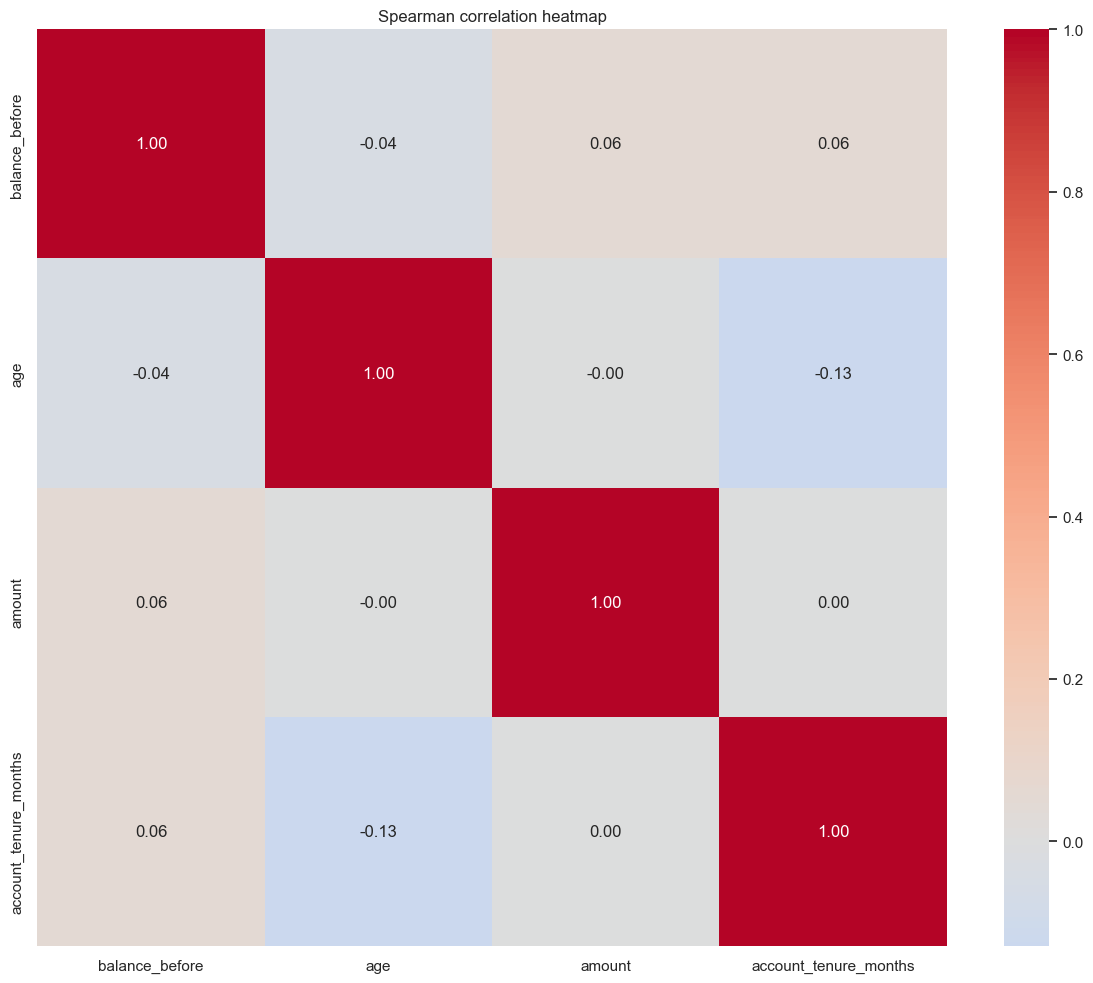

In [4]:
corr = correlation_heatmap(df, target='is_fraud', method='spearman', figsize=(12,10), annot=True, fmt='.2f', top_n=25)

**Key takeaways**

* All correlations are very weak (|r| < 0.15), features are largely independent.
* That’s actually good for modeling: less risk of multicollinearity, each variable can contribute unique information.
* The only slightly notable one is age ↔ account_tenure_months (r ≈ -0.13), but it’s still too weak to worry about.

> Hence:

* Numerical features are independent, which is good for fraud detection.
* No need feature decorrelation (like PCA just to fix collinearity).
* Focus more on categorical encodings and interaction features (e.g., amount / balance_before) rather than worrying about raw correlation.

### Univariate Analysis

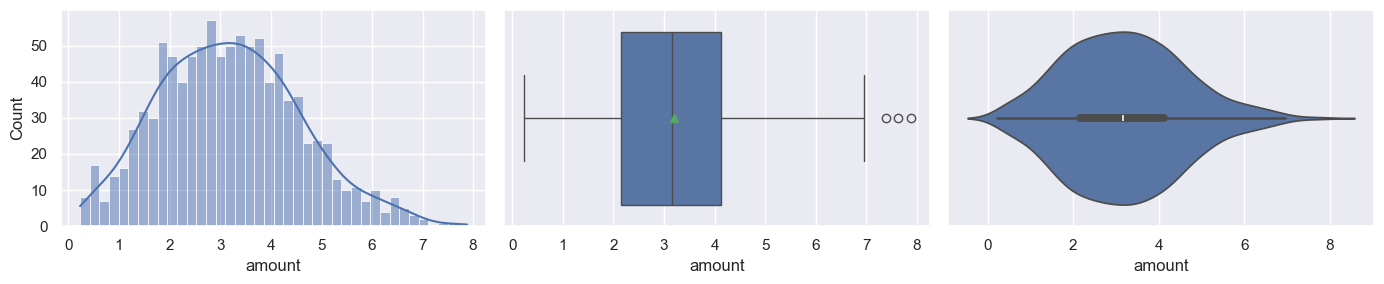

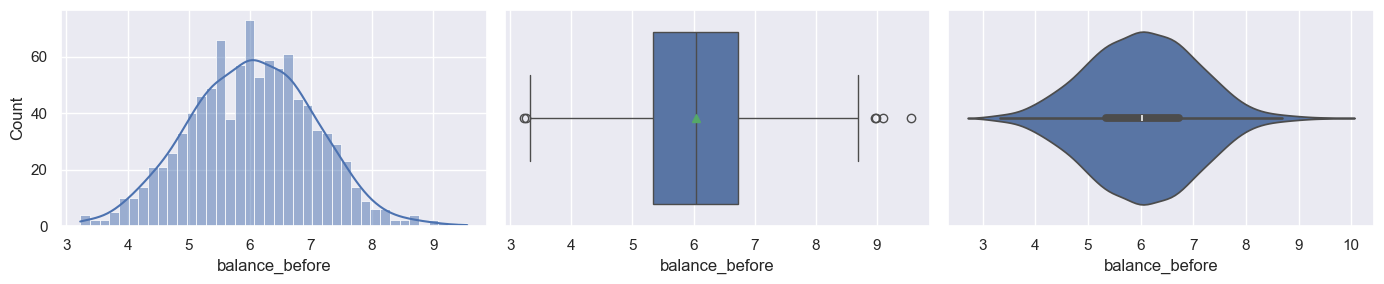

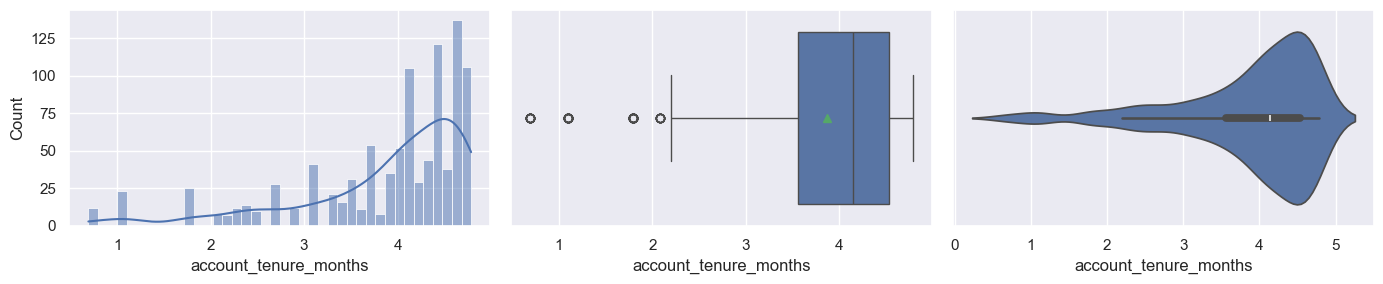

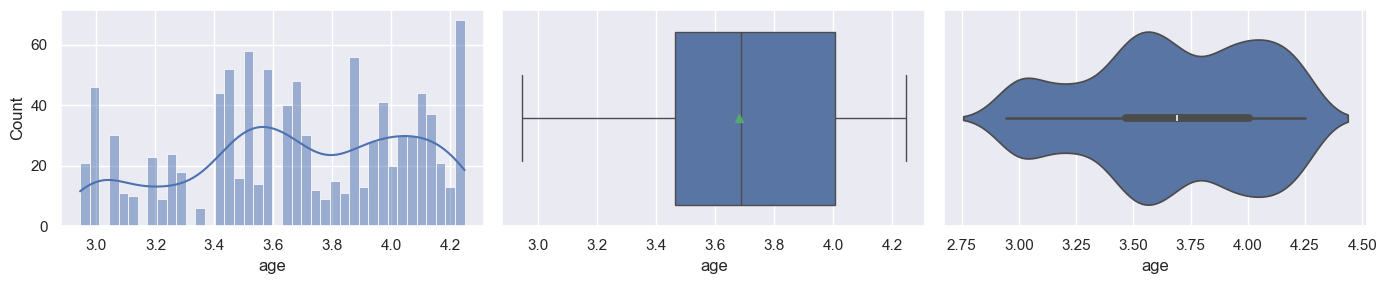

In [5]:
# univariate numeric
num_feats = [c for c in ['amount','balance_before','account_tenure_months','age'] if c in df.columns]
univariate_numerical(df, features=num_feats, log_transform=True, sample=20000)

The numerical columns are mostly normally distributed with few outliers, which won't be treated due to the kind of modelthat will be built.

### Categories and Multivariate Analysis


== merchant_category ==


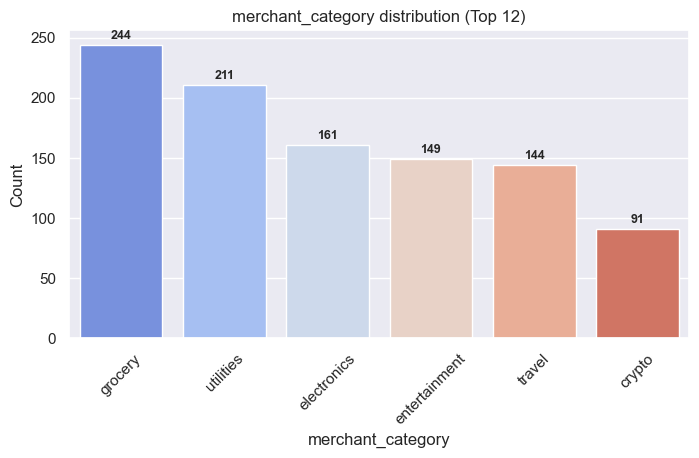

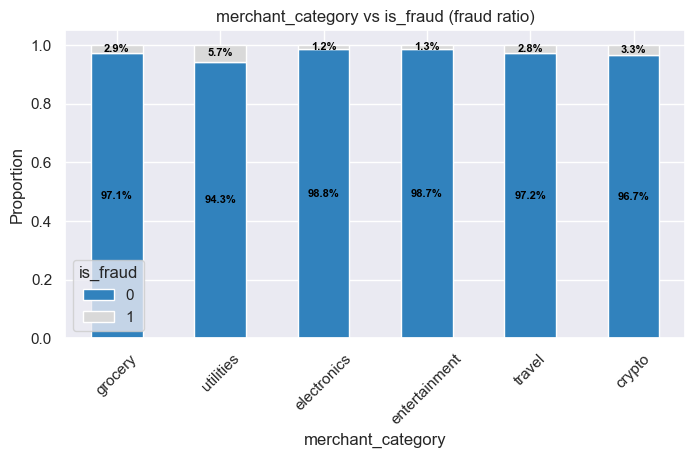


== device_type ==


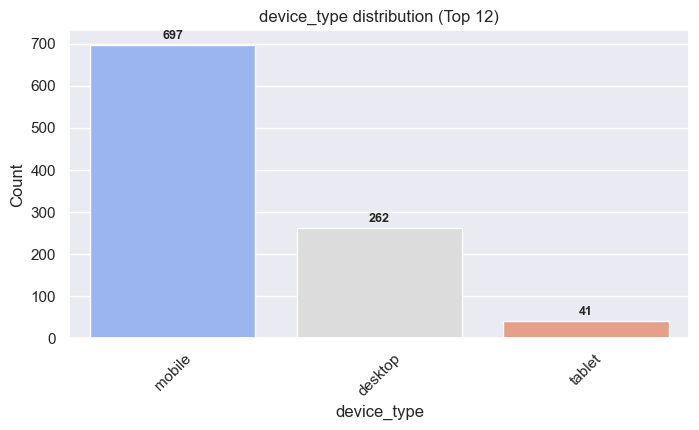

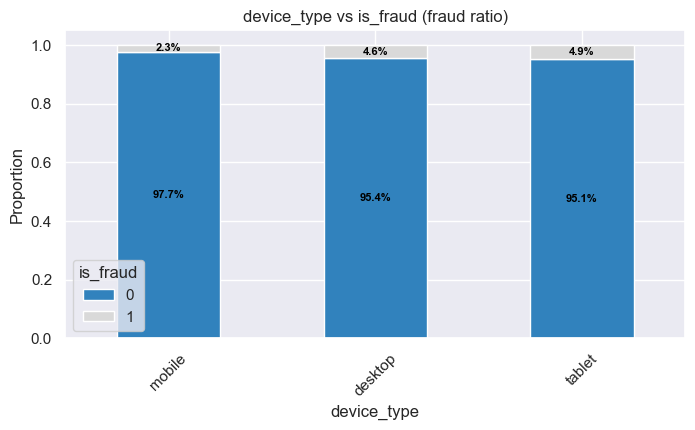


== channel ==


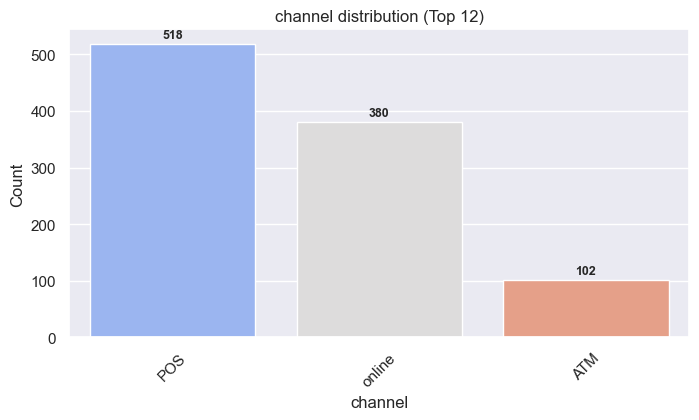

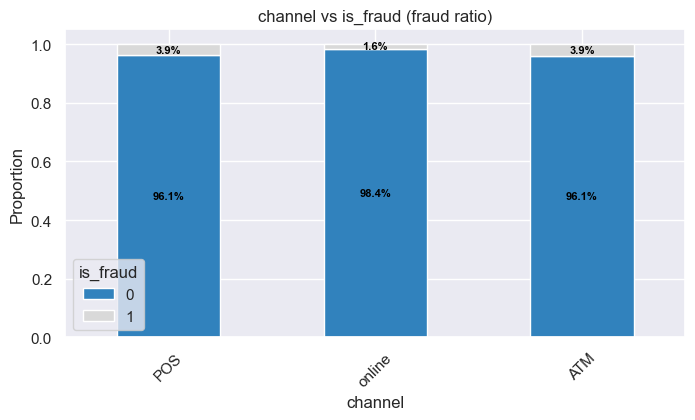


== tx_type ==


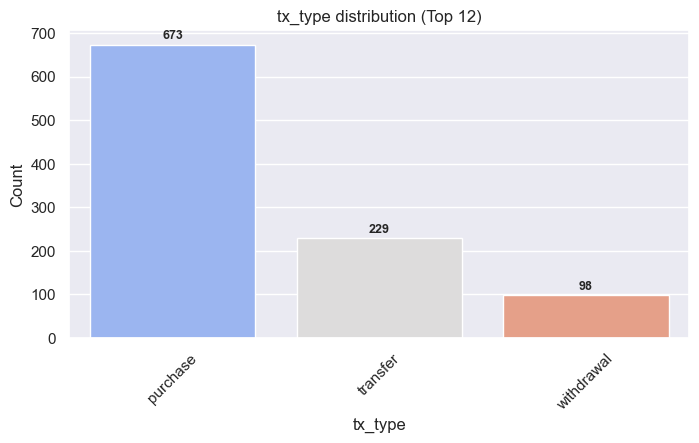

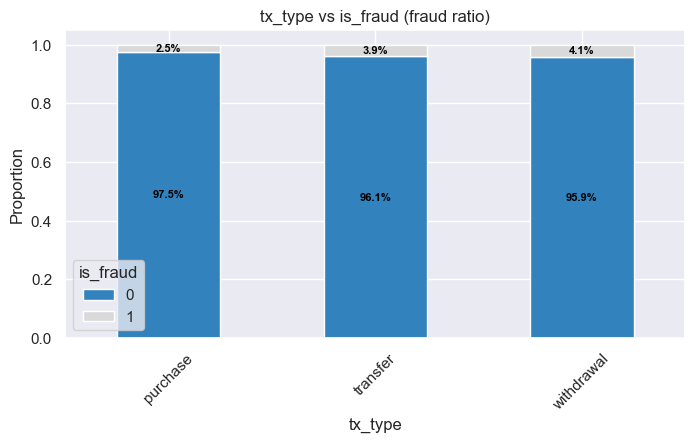

In [6]:
# categorical checks: counts + stacked fraud proportion for top categories
cat_candidates = [c for c in ['merchant_category','device_type','channel','country','tx_type','gender'] if c in df.columns]
for c in cat_candidates:
    print('\n==', c, '==')
    univariate_categorical(df, feature=c, target='is_fraud', top_n=12)

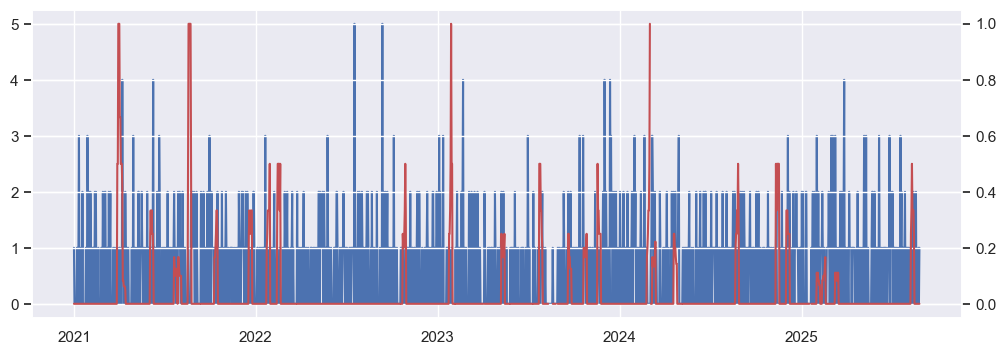

,count,fraud_sum,fraud_rate,fraud_rate_roll
timestamp,,,,
2025-08-21,0,0,NaN,0.0
2025-08-22,0,0,NaN,0.0
2025-08-23,1,0,0.0,0.0
2025-08-24,0,0,NaN,0.0
2025-08-25,1,0,0.0,0.0


In [7]:
# time series counts and fraud rate (daily)
ts = time_series_counts(df, time_col='timestamp', freq='D', target='is_fraud', rolling=7)
ts.tail()

**Interpretation:**

**Transaction activity (blue, left y-axis)**

* Fairly consistent baseline of transactions across all years (most points between 1–3, occasional spikes to 4–5).

* This indicates steady customer activity without major seasonal gaps.

**Fraud signals / rate (red, right y-axis)**

* Very spiky: most of the time it’s near zero, but at scattered points it shoots up sharply (close to 0.8–1).

* Suggests fraud is rare, but when it happens, it comes in bursts.

**Temporal pattern**

* Fraud spikes appear irregular: no clear annual seasonality (e.g., not every December or mid-year). But there are clusters — e.g., around 2022 and 2024 you see higher bursts.

**Implications for modeling**

* Fraud rate is extremely low and sporadic, reinforces class imbalance problem.
* A fixed threshold will likely perform poorly; hence a need for Precision@k or PR-AUC to evaluate.
* Dynamic thresholds or alerting systems when red spikes deviate from baseline.

**Summary:**

Most users transact steadily over time, but fraud cases occur sporadically in sudden bursts rather than evenly spread out.

This highlights the need for imbalance-aware methods (resampling) and maybe time-aware validation to ensure the model doesn’t overfit past patterns but can generalize to new fraud waves.

### Mutual Information

In [8]:
# mutual information (top signals)
mi = mutual_info_scores(df, target='is_fraud', n_top=25, sample=20000)
mi.head(10)



,feature,mi
19,location_Other NG,0.014898
12,channel_online,0.006850
3,balance_before,0.006560
10,device_type_tablet,0.006258
20,location_Port Harcourt,0.005592
2,amount,0.005373
15,location_GB,0.002182
11,channel_POS,0.001856
13,location_CN,0.001798
0,age,0.001233


**Key takeaways**

1. Location + channel dominate, fraud is strongly tied to where and how the transaction happened.
2. Behavioral/transactional features like balance_before and amount matter but are weaker.
3. Demographics (age), not very useful.
4. MI scores are all relatively small, none of the features alone is very predictive; fraud is multi-factorial.

> This suggests that feature interactions (e.g., online + location) may matter more than any one feature alone.

### Feature Importance

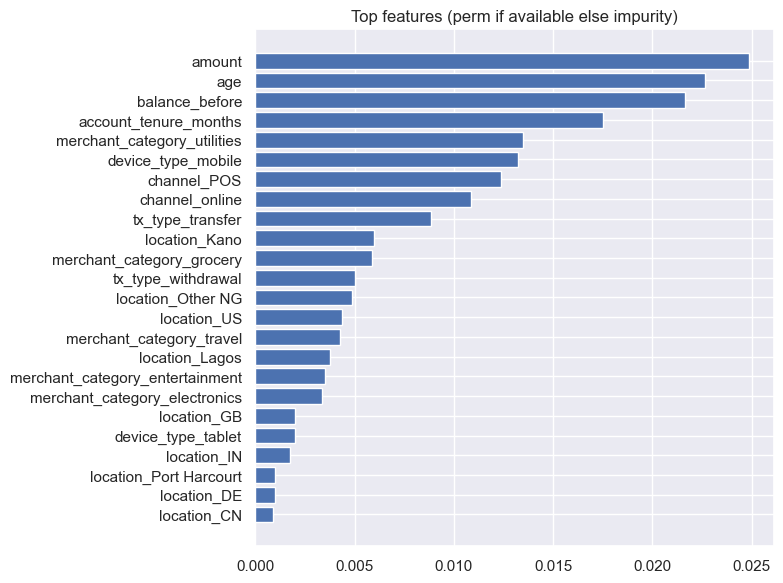

,feature,importance,perm_mean
0,amount,0.180724,0.024875
1,age,0.125593,0.022625
2,balance_before,0.212502,0.021625
3,account_tenure_months,0.122179,0.017500
4,merchant_category_utilities,0.030345,0.013500
5,device_type_mobile,0.028696,0.013250
6,channel_POS,0.024365,0.012375
7,channel_online,0.019839,0.010875
8,tx_type_transfer,0.031331,0.008875
9,location_Kano,0.021212,0.006000


In [9]:
# quick feature importance via RandomForest
imp = quick_feature_importance(df, target='is_fraud', n_top=25, sample=20000)
imp.head(10)

**Key takeaways**

1. Location + channel dominate, fraud is strongly tied to where and how the transaction happened.
2. Behavioral/transactional features like balance_before and amount matter but are weaker.
3. Demographics (age),  not very useful.
4. MI scores are all relatively small, none of the features alone is very predictive; fraud is multi-factorial.

> This suggests that feature interactions (e.g., online + location) may matter more than any one feature alone.

Next steps:

**Build interaction features:**

* amount / balance_before (relative spend).
* tenure × channel (new users online vs old users POS).
* Build nonlinear models (XGBoost, RF), they exploit interactions.

## Drift Test

In [10]:
# drift tests: numeric KS + PSI, categorical chi2
num_features = [c for c in ['amount','balance_before','account_tenure_months','age'] if c in df.columns and c in df_drift.columns]
for col in num_features:
    ks = ks_test_numeric(df[col], df_drift[col])
    ps = psi(df[col], df_drift[col], bins=10)
    print(f"{col}: KS_stat={ks.get('statistic')}, p={ks.get('pvalue')}; PSI={ps:.4f}")

cat_features = [c for c in ['country','merchant_category','device_type'] if c in df.columns and c in df_drift.columns]
for c in cat_features:
    ch = categorical_chi2(df[c], df_drift[c])
    print(f"{c}: chi2={ch.get('chi2')}, p={ch.get('pvalue')}, l1={ch.get('l1')}")

amount: KS_stat=0.022, p=0.9690010280430694; PSI=0.0034
balance_before: KS_stat=0.096, p=0.0001969751018672361; PSI=0.0414
account_tenure_months: KS_stat=0.0, p=1.0; PSI=0.0000
age: KS_stat=0.0, p=1.0; PSI=0.0000
merchant_category: chi2=156.098652478104, p=4.796400935217294e-29, l1=None
device_type: chi2=96.4608858642676, p=8.960551431335548e-21, l1=None


**Continuous features**

* amount: KS = 0.022, p ≈ 0.97, PSI = 0.0034
    
    No significant drift. Distribution of transaction amounts is very stable.
* balance_before: KS = 0.096, p ≈ 0.0002, PSI = 0.0414
    
    Statistically significant drift (p < 0.05).
    PSI = 0.041, still in the “small drift” range (PSI < 0.1 = stable, 0.1–0.25 = moderate, >0.25 = severe).
    > Meaning: balances shifted slightly, but not enough to break models. Worth monitoring.

* account_tenure_months: KS = 0.0, p = 1.0, PSI = 0.0000

    No drift at all. Perfectly stable.

* age: KS = 0.0, p = 1.0, PSI = 0.0000

    No drift at all. Stable population age distribution.

**Categorical features**

* merchant_category: χ² = 156.1, p ≈ 4.8e-29

    Very strong evidence of drift. Distribution of merchant categories changed drastically (e.g., more online shopping, fewer utilities, etc.).

* device_type: χ² = 96.5, p ≈ 8.9e-21

* Strong drift. Customers are using different devices than before (maybe more mobile vs desktop, etc.).

**Interpretation**

* Stable features: amount, account_tenure_months, age.

    Slight drift: balance_before (still safe but monitor).

* Major drift: merchant_category, device_type — model may degrade if it heavily depends on these.

In [ ]:
# # save quick artifacts
# out = Path('../artifacts/eda_outputs'); out.mkdir(parents=True, exist_ok=True)
# corr.to_csv(out/'correlation_matrix.csv')
# mi.to_csv(out/'mutual_info.csv', index=False)
# imp.to_csv(out/'rf_importances.csv', index=False)
# print('Saved correlation, mi, importances to', out)

Saved correlation, mi, importances to ..\artifacts\eda_outputs
